# Google Play Store Data

We will predit the rating of a Google Play Store app as a function of its attributes. We get our data from this source: https://www.kaggle.com/lava18/google-play-store-apps

Our first step will be to import all of the modules we need, and then load the data.

In [1]:
import Pkg
Pkg.add("CSV")
# Pkg.add("Plots")
Pkg.add("DataFrames")
Pkg.add("Statistics")
Pkg.add("StatsPlots")
Pkg.add("Measures")

using Random
Random.seed!(13)

using CSV
# using Plots
using DataFrames
using StatsPlots
using Statistics
using LinearAlgebra
using Measures
PyPlot()

   Updating registry at `~/.julia/registries/General`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


LoadError: UndefVarError: PyPlot not defined

In [2]:
apps = CSV.read("googleplaystore.csv", pool=false)
names!(apps, Symbol.(replace.(string.(names(apps)), Ref(r"\s"=>"")))) #remove whitespace from column names
feature_names = names(apps)
for i in 1:13
    println(string(i), "\t", string(feature_names[i]), "\t\t\t", string(eltype(apps[!, i])))
end

thread = 1 warning: only found 12 / 13 columns around data row: 10474. Filling remaining columns with `missing`
thread = 1 warning: only found 12 / 13 columns around data row: 10474. Filling remaining columns with `missing`
1	App			String
2	Category			String
3	Rating			Float64
4	Reviews			String
5	Size			String
6	Installs			String
7	Type			String
8	Price			String
9	ContentRating			Union{Missing, String}
10	Genres			String
11	LastUpdated			String
12	CurrentVer			Union{Missing, String}
13	AndroidVer			Union{Missing, String}


# (A) Clean Data

In [3]:
#Clean Ratings column 

new_ratings = Float64[]
for idx=1:size(apps,1)
    if !isnan(apps[idx, :Rating])
        push!(new_ratings, apps[idx, :Rating])
    end
end 
        
for idx=1:size(apps,1)
    if isnan(apps[idx, :Rating])
        apps[idx, :Rating]=round(mean(new_ratings), digits=1)   #set NaN Rating values equal to the mean 
    end
end

In [4]:
#Clean Size column

"This function converts strings to floating point values.
Strings that cannot be represented as a number (like NA) are converted to zeros"
function string_to_float(str)
    try
        parse(Float64, str)
    catch
       0.0
    end
end

for idx=1:size(apps,1)
    apps[idx, :Size] = rstrip(apps[idx, :Size], 'M')
    if rstrip(apps[idx, :Size], 'k') != apps[idx, :Size]
        apps[idx, :Size] = string((round(string_to_float(rstrip(apps[idx, :Size], 'k'))/1000, digits=1)))
    end
    if lstrip(apps[idx, :Size], 'V') != apps[idx, :Size]
        apps[idx, :Size] = ""
    end
end

typeof(apps[:, :Size])

Array{String,1}

In [5]:
#Clean Installs column

for idx=1:size(apps,1)
    apps[idx, :Installs] = replace(rstrip(apps[idx, :Installs], '+'), "," => "")
end

In [6]:
#Clean Type column

apps = filter(row -> !(row.Type in ["NaN"]), apps);

for idx=1:size(apps,1)
    if apps[idx, :Type] == "0"
        apps[idx, :Type] = "Free"
    end
end 

typeof(apps[:, :Type])

Array{String,1}

In [7]:
#Clean Content Rating column 

new_content_ratings = String[]
for idx=1:size(apps,1)
    if ismissing(apps[idx, :ContentRating])
        push!(new_content_ratings, "Unrated")
    else
        push!(new_content_ratings, apps[idx, :ContentRating])
    end
end 

apps = select!(apps, Not(:ContentRating))
insert!(apps, 9, new_content_ratings, :ContentRating)
typeof(apps[:, :ContentRating])


Array{String,1}

In [8]:
#Clean Category column 

apps = filter(row -> !(row.Category in ["1.9"]), apps);

# (B) Train/Test Split

To make the 80 / 20 train test split, we are going to shuffle the data, and then select the first 80%
  as the train data, with 20%
  held out for validation.

In [9]:
feature_names = names(apps)

apps = apps[shuffle(1:end), :] # we shuffle the data so that our train/test split will be truly random

train_proportion = 0.8
n = size(apps, 1)
println("Size of dataset: ", string(n))

# Put the first ntrain observations in the DataFrame df into the training set, and the rest into the test set
ntrain = convert(Int, round(train_proportion*n))
ntest = n-ntrain

target = apps[:, :Rating]
data = apps[:, filter(col -> (col != :Rating), feature_names)]

# the following variable records the features of examples in the training set
train_x = data[1:ntrain,:]
# the following variable records the features of examples in the test set
test_x = data[ntrain+1:n,:]
# the following variable records the labels of examples in the training set
train_y = target[1:ntrain,:]
# the following variable records the labels of examples in the test set
test_y = target[ntrain+1:n,:]

Size of dataset: 10839


2168×1 Array{Float64,2}:
 4.5
 3.9
 4.3
 3.4
 4.0
 3.7
 4.2
 4.5
 3.5
 4.2
 4.6
 3.6
 4.3
 ⋮
 4.2
 4.1
 3.9
 3.8
 4.4
 3.8
 4.3
 5.0
 4.7
 4.3
 4.2
 4.3

In [10]:
labels_real = [
    :Reviews,
    :Size,
    :Installs
]

3-element Array{Symbol,1}:
 :Reviews
 :Size
 :Installs

In [11]:
train_vals_real = convert(Matrix, string_to_float.(train_x[:, labels_real]))
test_vals_real = convert(Matrix, string_to_float.(test_x[:, labels_real]))

train_vals_real = hcat(train_vals_real, ones(ntrain, 1))
test_vals_real = hcat(test_vals_real, ones(ntest, 1))

2168×4 Array{Float64,2}:
  73539.0  96.0       1.0e6  1.0
  28429.0  14.0       5.0e6  1.0
 192374.0  56.0       1.0e7  1.0
     30.0   3.0   10000.0    1.0
   4332.0  12.0       1.0e6  1.0
    166.0   2.0    5000.0    1.0
      0.0   3.4      50.0    1.0
 212626.0  11.0       1.0e7  1.0
  14823.0  40.0       1.0e6  1.0
  67772.0   0.0       5.0e6  1.0
    603.0   7.4   10000.0    1.0
   5692.0  31.0       1.0e6  1.0
    176.0   2.3  100000.0    1.0
      ⋮                      
      5.0  44.0     500.0    1.0
    331.0  10.0   50000.0    1.0
  60841.0   0.0       5.0e6  1.0
    103.0   6.9    5000.0    1.0
  12683.0  19.0       1.0e6  1.0
   1093.0   0.0  100000.0    1.0
  32584.0   0.0       1.0e6  1.0
      9.0   1.5     100.0    1.0
  20001.0   0.0       1.0e6  1.0
     33.0  46.0    1000.0    1.0
     10.0   3.0     500.0    1.0
   4551.0  79.0  500000.0    1.0

In [12]:
"""This function just computes the mean squared error."""
function MSE(y, pred)
    return mean((y .- pred) .^ 2)
end

MSE

In [13]:
"""This function plots the main diagonal;
for a "predicted vs true" plot with perfect predictions,
all data lies on this line"""
function plotDiagonal(xmin, xmax)
    xsamples = [xmin, xmax]
    plot!(xsamples, xsamples, color=:black)
end

plotDiagonal

In [14]:
"""This helper funciton plots x vs, y and labels the axes."""
function plotdata(x,y,xname, yname; margin=0.05, plotDiag=true, zeromin=false)
    scatter(x,y, label="data")
    xlabel!(xname)
    ylabel!(yname)
    range_y = maximum(y) - minimum(y)
    range_x = maximum(x) - minimum(x)
    if plotDiag
        plotDiagonal(minimum(x)-margin*range_x, maximum(x)+margin*range_x)
    end
    if zeromin
        ylims!((0.0,maximum(y)+margin*range_y))
        xlims!((0.0,maximum(x)+margin*range_x))
    else
        ylims!((minimum(y)-margin*range_y,maximum(y)+margin*range_y))
        xlims!((minimum(x)-margin*range_x,maximum(x)+margin*range_x))
    end
end

plotdata

In [15]:
"""This function plots the predicted labels vs the actual labels
(We only plots the first 1000 points to avoid slow plots.)"""
function plot_pred_true(test_pred, test_y, max_points = 1000)
    plotdata(test_pred[1:max_points], test_y[1:max_points], "Predicted Rating", "True Rating", zeromin=true)
end

plot_pred_true

In [16]:
# The weights of your linear equation (compute via least squares)
w = train_vals_real \ train_y

#Your prediction vectors
train_pred = [sum(w.*train_vals_real[i, :]) for i=1:size(train_vals_real, 1)] 
test_pred = [sum(w.*test_vals_real[i, :]) for i=1:size(test_vals_real, 1)] 

#The mean squared error for your predictions.
train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

0.23329568860039016

Train MSE	0.22661988818515005
Test MSE 	0.23329568860039016


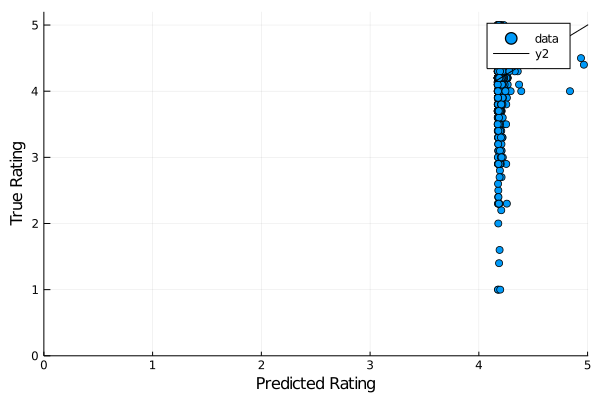

In [17]:
println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

plot_pred_true(test_pred, test_y)

# (C) One-Hot Encoding

In [18]:
# Create one hot encoding for category-type columns 

cat_labels = [
    :Category,
    :Type,
    :ContentRating
]

#Sets of all categories in a particular column
cats_sets = [unique(train_x[:, label]) for label in cat_labels]

3-element Array{Array{String,1},1}:
 ["PHOTOGRAPHY", "LIBRARIES_AND_DEMO", "MEDICAL", "LIFESTYLE", "BUSINESS", "GAME", "TOOLS", "FAMILY", "FINANCE", "NEWS_AND_MAGAZINES"  …  "SPORTS", "EVENTS", "EDUCATION", "WEATHER", "FOOD_AND_DRINK", "ENTERTAINMENT", "BOOKS_AND_REFERENCE", "BEAUTY", "MAPS_AND_NAVIGATION", "PARENTING"]
 ["Paid", "Free"]
 ["Everyone", "Teen", "Everyone 10+", "Mature 17+", "Adults only 18+", "Unrated"]

In [19]:
"Computes a onehot vector for every entry in column given a set of categories cats"
function onehot(column, cats=unique(column))
    n = size(column,1) 
    d = size(cats,1) 
    result = zeros(n, d)
    for i = 1:n 
        for j=1:d
            if column[i] == cats[j] 
                result[i, j] = 1
            end 
        end
    end
    return result
end

onehot

In [20]:
category_onehot = onehot(train_x[:, :Category], cats_sets[1])

8671×33 Array{Float64,2}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

In [21]:
type_onehot = onehot(train_x[:, :Type], cats_sets[2])

8671×2 Array{Float64,2}:
 1.0  0.0
 0.0  1.0
 0.0  1.0
 0.0  1.0
 0.0  1.0
 0.0  1.0
 0.0  1.0
 0.0  1.0
 0.0  1.0
 0.0  1.0
 0.0  1.0
 0.0  1.0
 0.0  1.0
 ⋮    
 0.0  1.0
 1.0  0.0
 1.0  0.0
 0.0  1.0
 1.0  0.0
 0.0  1.0
 0.0  1.0
 0.0  1.0
 0.0  1.0
 0.0  1.0
 0.0  1.0
 0.0  1.0

In [22]:
content_rating_onehot = onehot(train_x[:, :ContentRating], cats_sets[3])

8671×6 Array{Float64,2}:
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0

In [23]:
train_cat_vals = hcat([onehot(train_x[:, cat_labels[i]], cats_sets[i]) for i in 1:size(cat_labels, 1)]...)
test_cat_vals = hcat([onehot(test_x[:, cat_labels[i]], cats_sets[i]) for i in 1:size(cat_labels, 1)]...) 

2168×41 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  …  1.0  0.0  0.0  0.0  1.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     1.0  1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     1.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  1.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

Train MSE	0.22012219576797956
Test MSE 	0.230918724362971


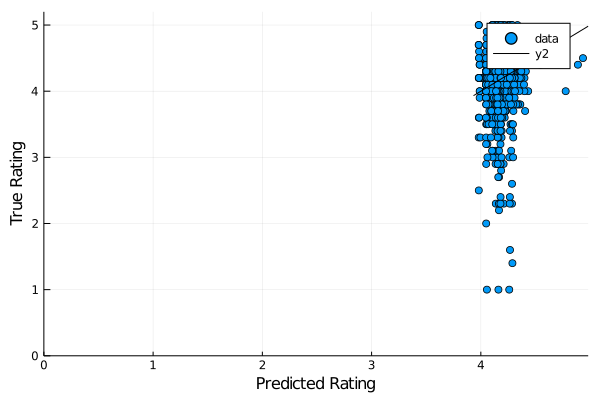

In [24]:
train_vals = hcat(train_cat_vals, train_vals_real)
test_vals = hcat(test_cat_vals, test_vals_real)

w = train_vals \ train_y 

train_pred = [sum(w.*train_vals[i, :]) for i=1:size(train_vals, 1)] 
test_pred = [sum(w.*test_vals[i, :]) for i=1:size(test_vals, 1)] 

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)
        
println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

plot_pred_true(test_pred, test_y)

# (D) Many-Hot Encoding

In [25]:
print(train_x[1:100, :Genres])

["Photography", "Libraries & Demo", "Medical", "Lifestyle", "Business", "Medical", "Racing", "Photography", "Tools", "Education", "Finance", "Business", "News & Magazines", "Shopping", "News & Magazines", "Tools", "Social", "Tools", "Puzzle", "Travel & Local", "Education", "House & Home", "Casual;Action & Adventure", "Productivity", "Video Players & Editors", "Education;Pretend Play", "Medical", "Health & Fitness", "Finance", "Business", "Casual", "Communication", "Medical", "House & Home", "Medical", "Personalization", "Dating", "News & Magazines", "Art & Design", "Auto & Vehicles", "Music", "Medical", "Tools", "Travel & Local", "Business", "Health & Fitness", "Education", "Dating", "Arcade", "Education", "Entertainment", "Communication", "Comics", "News & Magazines", "Business", "Personalization", "Photography", "Business", "Lifestyle", "Personalization", "Lifestyle", "Productivity", "Lifestyle", "Lifestyle", "Finance", "Shopping", "News & Magazines", "Communication", "Productivity",

In [26]:
split_genres(x) = split(x, ";")
example_genres = split_genres(train_x[4, :Genres])

1-element Array{SubString{String},1}:
 "Lifestyle"

In [27]:
genres_train = split_genres.(train_x[:, :Genres])
genres_test = split_genres.(test_x[:, :Genres])

2168-element Array{Array{SubString{String},1},1}:
 ["Role Playing"]
 ["Photography"]
 ["Racing"]
 ["Photography"]
 ["News & Magazines"]
 ["Communication"]
 ["Medical"]
 ["Dating"]
 ["Action"]
 ["Weather"]
 ["Books & Reference"]
 ["Video Players & Editors"]
 ["Productivity"]
 ⋮
 ["Education"]
 ["Shopping"]
 ["Entertainment"]
 ["Finance"]
 ["Action"]
 ["News & Magazines"]
 ["Business"]
 ["Tools"]
 ["Weather"]
 ["Tools"]
 ["Entertainment"]
 ["Simulation"]

In [28]:
genre_types = unique(vcat(genres_train...))

53-element Array{SubString{String},1}:
 "Photography"
 "Libraries & Demo"
 "Medical"
 "Lifestyle"
 "Business"
 "Racing"
 "Tools"
 "Education"
 "Finance"
 "News & Magazines"
 "Shopping"
 "Social"
 "Puzzle"
 ⋮
 "Board"
 "Brain Games"
 "Creativity"
 "Beauty"
 "Casino"
 "Trivia"
 "Strategy"
 "Maps & Navigation"
 "Word"
 "Parenting"
 "Educational"
 "Music & Audio"

In [29]:
"Computes a manyhot vector for every entry in an array of arrays given a set of categories cats"
function manyhot(column, cats=unique(col))
    n = size(column, 1)
    d = size(cats, 1)
    result = zeros(n, d)
    
    for i = 1:n
        set_of_descriptions = column[i]
        for j = 1:d 
            if cats[j] in set_of_descriptions
                result[i, j] = 1 
            end
        end
    end 
    result
end

manyhot

In [30]:
genre_vals_train = manyhot(genres_train, genre_types)
genre_vals_test = manyhot(genres_test, genre_types)

2168×53 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

Train MSE	0.21807514757106583
Test MSE 	0.22873714589748045


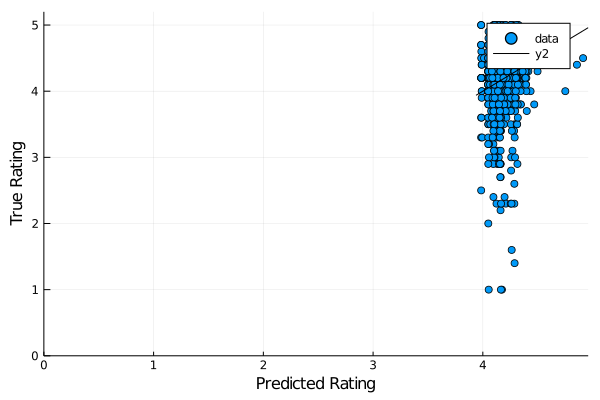

In [31]:
train_vals = hcat(genre_vals_train, train_vals)
test_vals = hcat(genre_vals_test, test_vals)

w = train_vals \ train_y

train_pred = [sum(w.*train_vals[i, :]) for i=1:size(train_vals, 1)] 
test_pred = [sum(w.*test_vals[i, :]) for i=1:size(test_vals, 1)] 

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)
    
println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

plot_pred_true(test_pred, test_y)

# (E) Data Exploration

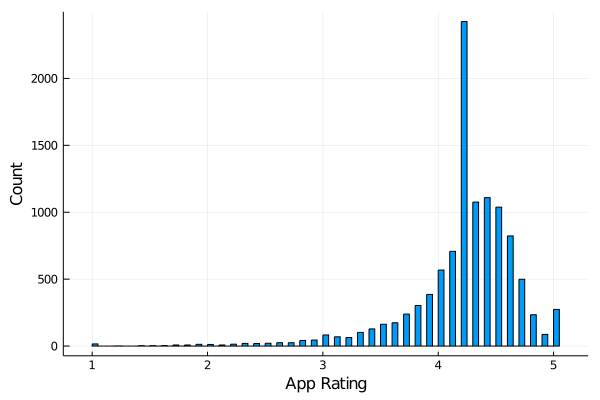

In [32]:
@df apps histogram(:Rating, xlabel="App Rating", ylabel="Count", legend=false)

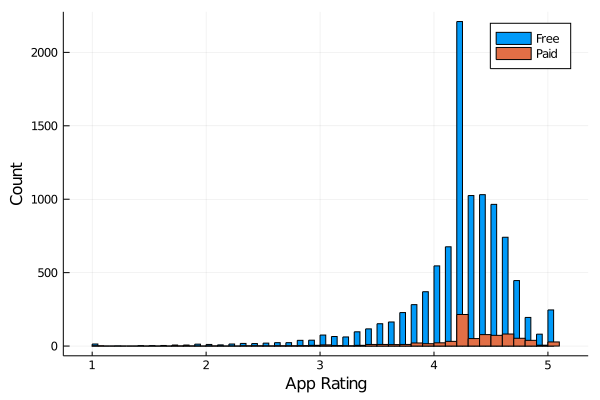

In [33]:
@df apps histogram(:Rating, group=:Type, xlabel="App Rating", ylabel="Count")

In [34]:
category_count = [] 
for idx=1:size(category_onehot,2)
    push!(category_count, sum(category_onehot[:, idx]))
end 
print(category_count)

Any[276.0, 69.0, 375.0, 301.0, 366.0, 927.0, 685.0, 1563.0, 297.0, 218.0, 203.0, 240.0, 212.0, 70.0, 339.0, 145.0, 264.0, 303.0, 319.0, 186.0, 50.0, 71.0, 52.0, 302.0, 52.0, 134.0, 57.0, 96.0, 120.0, 182.0, 42.0, 102.0, 53.0]

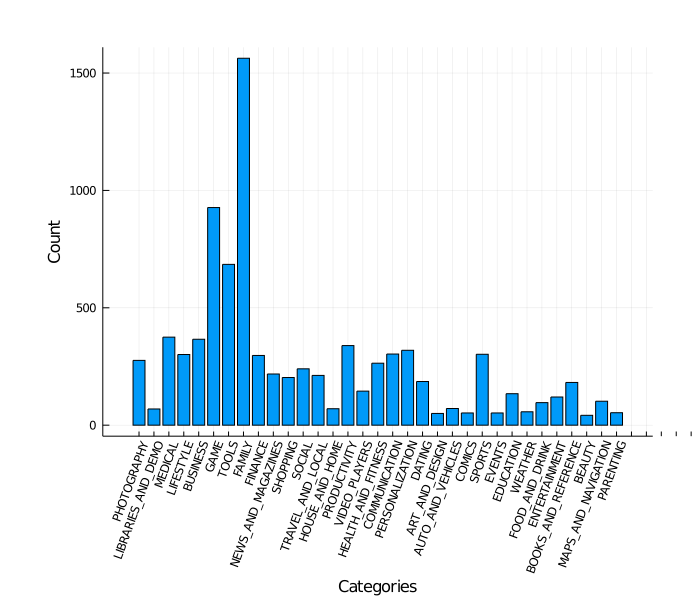

In [35]:
bar(category_count, xticks = (1:53, cats_sets[1]), xrotation=70, margin=10mm, legend=false, xlabel="Categories", ylabel="Count")
plot!(size=(700,600))

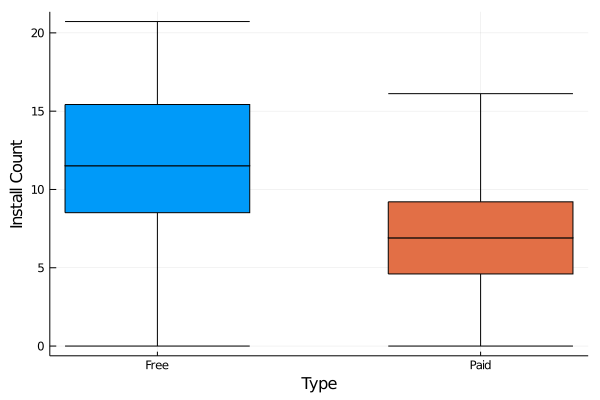

In [91]:
apps = filter(row -> !(row.Installs in ["NaN"]), apps);
apps_float = transform(apps, :Installs => ByRow(x -> string_to_float(x)) => :Installs)
apps_float = filter(row -> !(row.Installs in [0]), apps_float); # log(0) is undefined. 
apps_log = transform(apps_float, :Installs => ByRow(x -> log(x)) => :Installs)
@df apps_log boxplot(:Type, :Installs, group=:Type, legend=false, xlabel="Type", ylabel="Install Count")